In [1]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from time import time
from random import seed

In [ ]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

In [2]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
print(f'X shape: {X.shape}')

X_yes shape: (120, 214, 214)
X_no shape (83, 214, 214)
classes shape: (203,)


In [4]:
def get_data_augmentator(X):
    data_gen = ImageDataGenerator(
        rotation_range=30, # Rotation up to 30 degrees
        fill_mode='nearest', # Fill mode for new pixels after roatation
        height_shift_range=0.1, # Shift vertically up to 10% of img dimensions
        width_shift_range=0.1, # Shift horizontally up to 10% of img dimensions
        horizontal_flip=True, # Random flip over horizontal axis
        vertical_flip=True, # Random flip over vertical axis
        brightness_range=[0.8, 1.2], # Brightness change from 0.8 (darker) up to 1.2 (brighter)
    )
    return data_gen

## Perceptrón multi-capa con reducción de dimensionalidad PCA

X_tmp shape: (203, 203)
N_components: 203
Porcentaje de varianza acumulada: [0.20053596 0.26979397 0.31451247 0.34812596 0.37607219 0.40243568
 0.42581765 0.44683846 0.46572741 0.48380821 0.500779   0.51715022
 0.53218323 0.54572175 0.55903692 0.57157112 0.58367032 0.59570706
 0.60658944 0.61662166 0.62623261 0.63554886 0.64453848 0.65313407
 0.66132415 0.6693954  0.67737684 0.68492833 0.69210845 0.69905468
 0.70572209 0.71216272 0.71827146 0.7241818  0.72997372 0.73554452
 0.74101712 0.74625146 0.75137588 0.7562528  0.7609713  0.76564824
 0.77022825 0.7747463  0.77917507 0.78349049 0.78769519 0.79184544
 0.7959223  0.79983368 0.80368468 0.80748506 0.81112705 0.81473782
 0.81827451 0.82175445 0.82519709 0.82855656 0.83185071 0.83505709
 0.83824646 0.84142504 0.84453113 0.84757589 0.85057606 0.85355304
 0.85647638 0.85929657 0.86208986 0.8647862  0.86746558 0.8701083
 0.87272351 0.87528994 0.87782344 0.88029873 0.88272469 0.88510078
 0.88743371 0.88971833 0.89197691 0.89419933 0.8963940

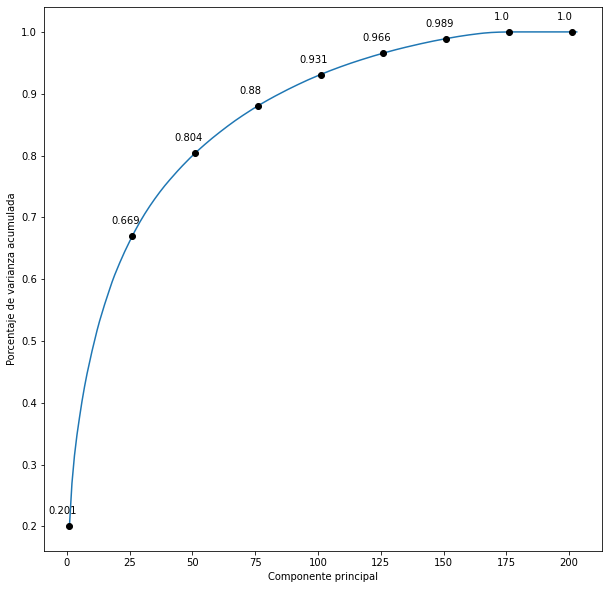

In [5]:
def draw_pca_variance(n_components, variance_cumsum):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.set_xlabel('Componente principal')
    ax.set_ylabel('Porcentaje de varianza acumulada')
    ax.plot(
        np.arange(1, n_components + 1),
        variance_cumsum,
    )
    i, aux = 0, 0
    for x, y in zip(np.arange(1, n_components + 1, 25), variance_cumsum[:-1:25]):
        ax.plot(x, y, 'ko')
        ax.annotate(
            np.round(y, 3),
            (x, y),
            textcoords='offset points',
            xytext=(-7, 12),
            ha='center'
        )
    plt.show()

def get_pca(X):
    pca = PCA(n_components=None)
    X_tmp = pca.fit_transform(X)
    n_components = pca.n_components_
    variance_cumsum = pca.explained_variance_ratio_.cumsum()
    print(f'X_tmp shape: {X_tmp.shape}')
    print(f'N_components: {n_components}')
    print(f'Porcentaje de varianza acumulada: {variance_cumsum}')
    draw_pca_variance(n_components, variance_cumsum)
    return pca

tmp_pca = get_pca(X)

In [6]:
sd = seed(time())

pipe = Pipeline([
    ('Scaler', StandardScaler()),
    ('PCA', PCA(n_components=None)),
    ('MLPClassifier', MLPClassifier(random_state=sd))
])

RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=sd)
hidden_layers = [(100, 50, 25), (200, 100, 50), (150, 75, 30, 10), (200, 100, 50, 25)]

grid_space = [
    {
        'MLPClassifier__solver': ['lbfgs', 'adam'],
        'MLPClassifier__max_iter': range(1000, 3500, 500),
        'MLPClassifier__activation': ['logistic', 'tanh', 'relu'],
        'MLPClassifier__hidden_layer_sizes': hidden_layers,
        'MLPClassifier__learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1]
    }, 
    {
        'MLPClassifier__solver': ['sgd'],
        'MLPClassifier__max_iter': range(1000, 3500, 500),
        'MLPClassifier__activation': ['logistic', 'tanh', 'relu'],
        'MLPClassifier__hidden_layer_sizes': hidden_layers,
        'MLPClassifier__learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
        'MLPClassifier__momentum': np.arange(0.1, 1, 0.1)
    }
]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=grid_space,
    cv=RSKFold,
    scoring='balanced_accuracy',
    return_train_score=True,
    verbose=4,
    n_jobs=-1
)


In [ ]:
res = grid.fit(X, classes)

## Perceptrón multi-capa con reducción de dimensionalidad PCA y *data augmentation*

In [1]:
import albumentations as A

In [2]:
imgs_trans = A.Compose([
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), p=0.25),
    A.Rotate(limit=[-30, 30], p=0.25),
    A.Affine(translate_percent=0.1)
])

In [3]:
def augmentate_data(imgs, aug_per_image):
    new_images = []
    for img, i in zip(imgs, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)
            new_images.append(tmp_img)
        if i % 50 == 0: print(f'{i} images agumented...')
    return new_images